# Tree Ensembles

Decision trees are very sensitive to small changes in the original training data.

Suppose we have the following two training data sets:

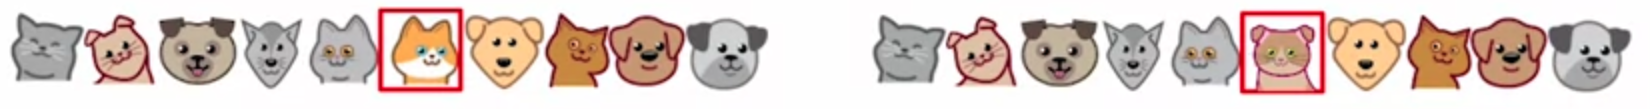

You will notice they only differ in a single training example, the one boxed in red.  These two cats have
the same face shape (round), but one has whiskers and one doesn't, and one has pointy ears and one has floppy
ears.

Though these two training sets both have almost the same set of animals in them, they will result in very
different decision trees when you run the decision tree learning algorithm on them:

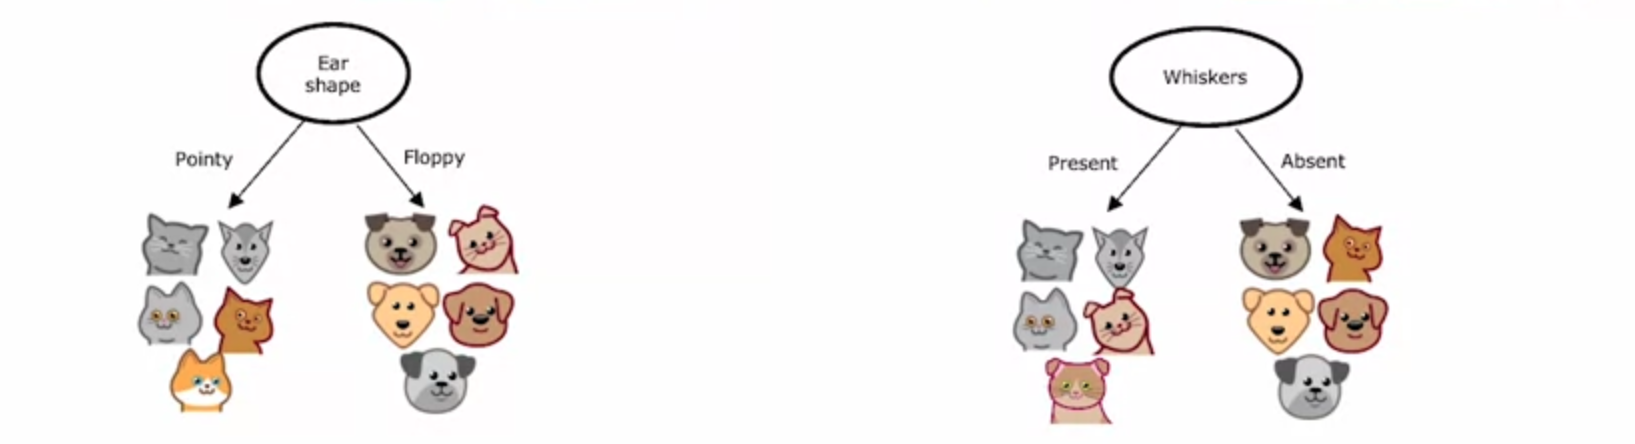

By just changing one cat, the best feature to split on changes from ear shape to whiskers.
And then the resulting left and right training subsets change entirely, which means the rest of
each tree will most likely be very different as well.

This is not a great thing, because it means the decision tree algorithm is not very robust, if it's
sensitive to such small changes in the data.  Because of this, it turns out that we often get more
accurate predictions on testing/new data if we train multiple decision trees and average their predictions
in some way.  This removes the individual influence of any single tree, removing some of the sensitivity to
small changes in the original data.

This is called **tree ensemble methods**.

For instance, here's a collection of three decision trees, all built from similar but not identical data
sets, used to predict whether or not an animal is a cat:

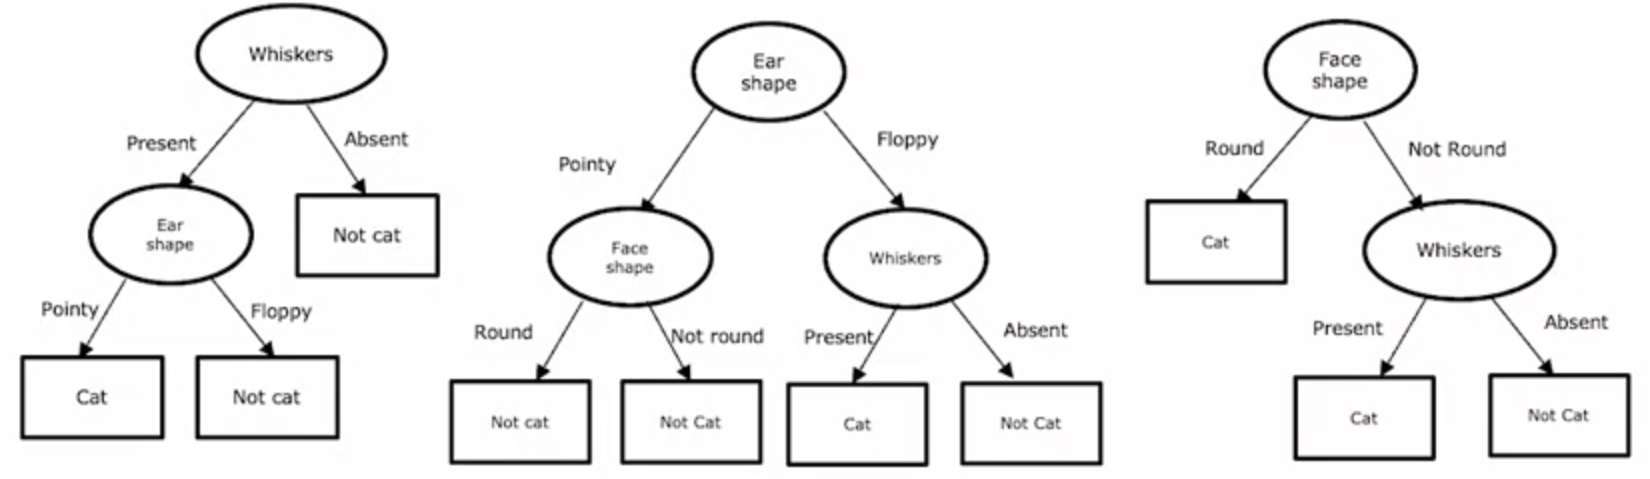

When we put this new cat through the three trees:

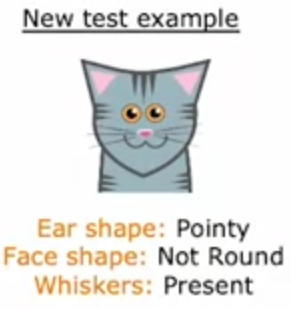

We get predictions (left to right) of "cat", "not cat", and "cat," and because the majority of these
trees predict "cat," that's the class we use for our prediction (which turns out to be correct in this
situation).

# Bagged Decision Trees and Random Forests



The bagged decision tree algorithm is one very common method of generating an "ensemble" or
collection of trees that all can vote on the output.  The key idea is that the decision tree
learning algorithm itself doesn't change from what we used earlier --- instead, we modify
the *training data set* that the algorithm is using.  Because we will get different trees for
different data sets, using a bunch of different data sets will naturally give us different trees.

Algorithm:

- Given a training set of size $m$:
- For $b = 1$ to $B$:
  - Use sampling with replacement to generate a new training set of size $m$ from the original one.
  - Train a decision tree on this new data set.
  
Example:

- Suppose we have our original ten training examples with cats and dogs:



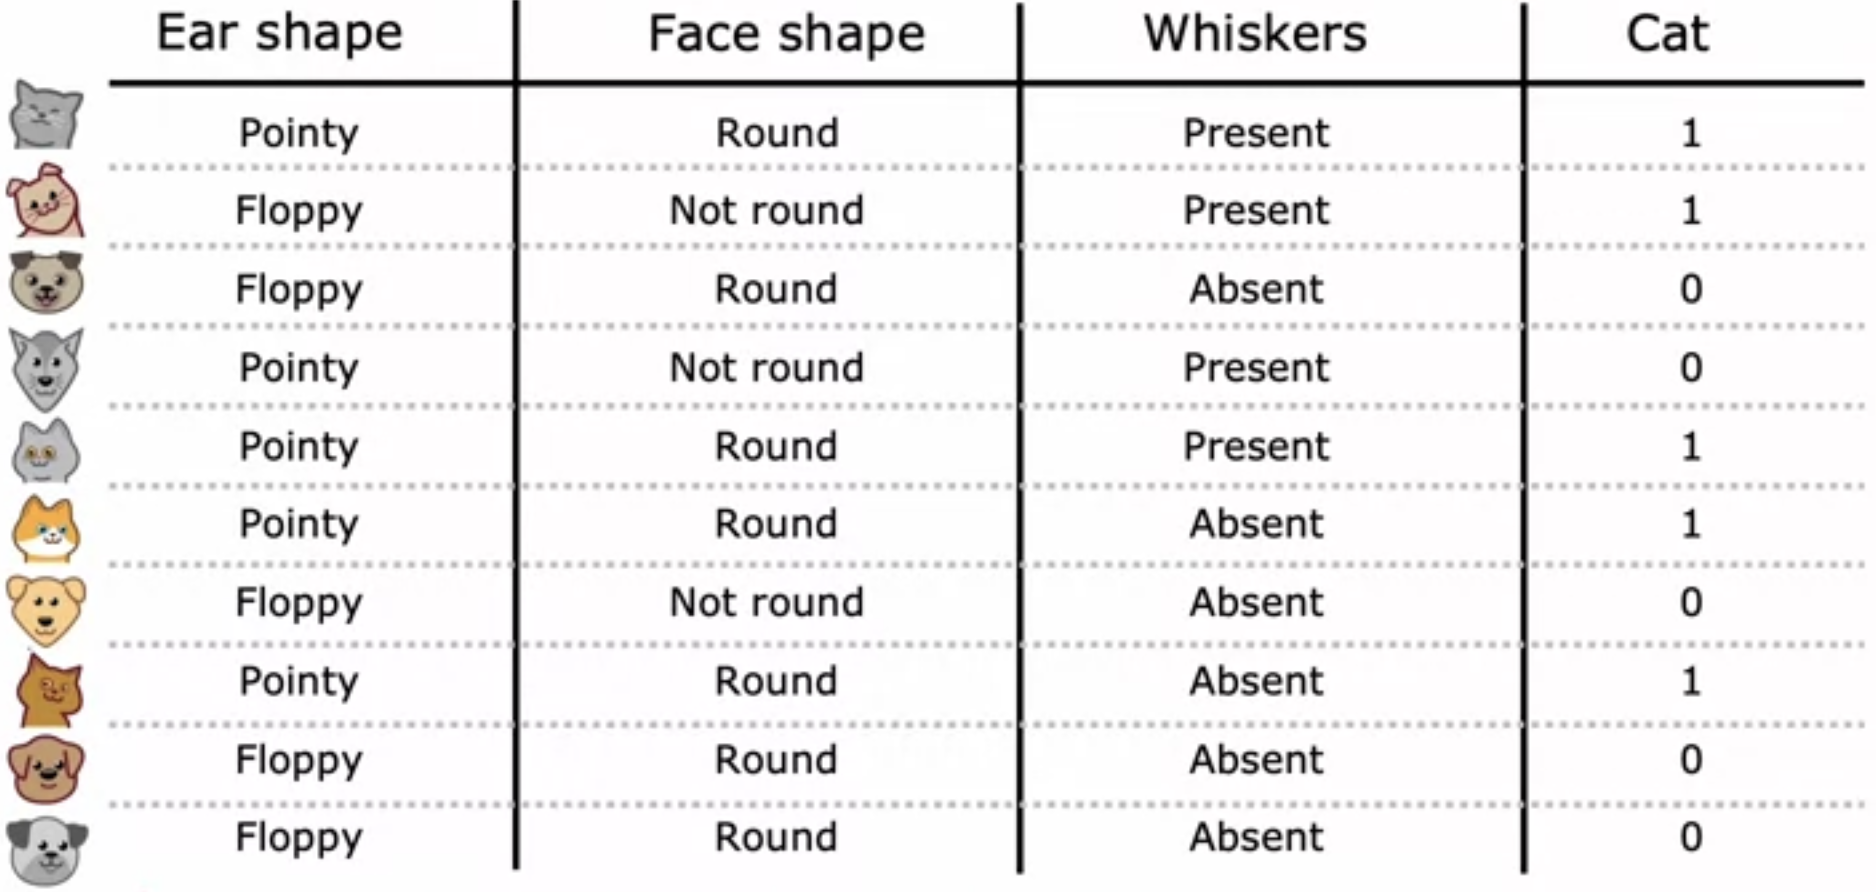

First, we generate a new data set via sampling with replacement from the ten examples above,
which might look like this:

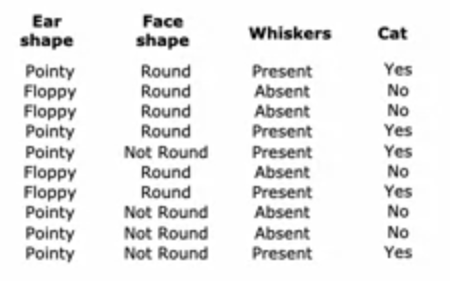

And the decision tree we get looks like this:

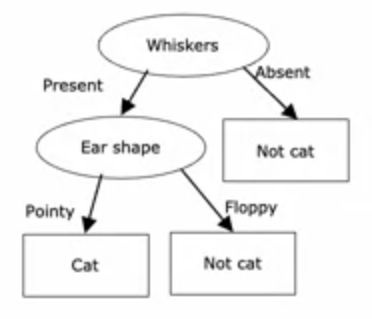

Then we generate a second data set (starting again with the **original** data set):

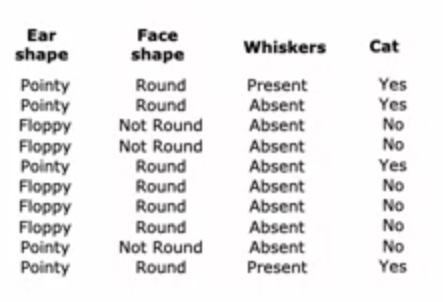

And we train a second decision tree on this data and end up with this:

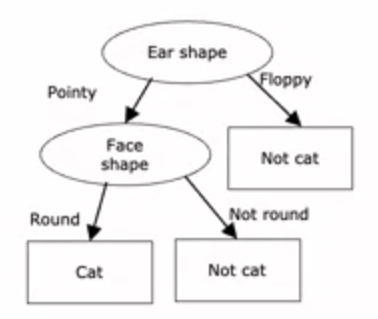

So we do this a total of $B$ times, and end up with $B$ total trees at the end.  These $B$ trees together
form our model.  To classify a new example, we use the normal decision tree classification algorithm
to put the new example through all $B$ trees, and have them collectively "vote" on the output: whichever
category is output as the majority is the prediction that the overall tree ensemble uses.
  
Notes:

- **Sampling with replacement**: This means that we are allowed to select the same example from the original
training set multiple times.  So we might end up with new data sets with duplicate elements!  This is ok, it's
what's intended.

- **What should $B$ be?** People tend to use values of $B$ around 100 in practice.  Values from 64 to 128
are typical.  Using more than that never results in *worse* performance, but there tends to be a diminishing
returns effect if you go too much past 100.

- **Bagging**: This general technique, of using an ensemble of models where each model is generated from 
the same starting data via sampling with replacement, is called **bagging**.  It helps to avoid overfitting
and also usually produces a model with lower variance than the individual models (having less sensitivity to small fluctuations in the input data).  Bagging is usually used with decision trees, but technically could be used
with any type of model.

From Wikipedia:

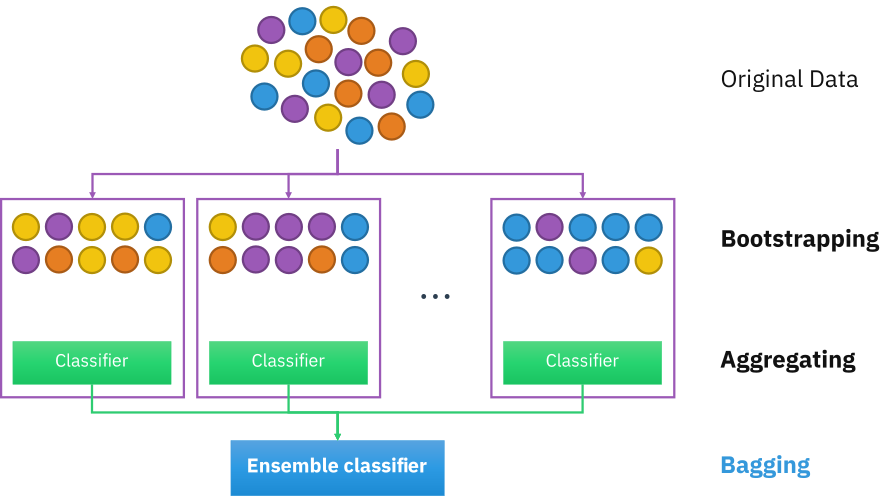

### Modifying bagged decision trees into random forests

The bagged decision tree algorithm above still tends to suffer one drawback:

- Even with sampling with replacement being used to generate the new individual data sets, it is common
to have the root node splitting feature and other features near the root node all end up identical in many of
the individual trees.  (This didn't happen in the two examples above, but it's very common.)  For instance,
it's not unheard of to generate $B$ new trees that all end up with the same feature to split on at the $B$ roots.

We can try to force the individual trees to use different features by the following modification:

- At each node, when choosing a feature to split on, if $n$ features are available, pick a random subset of
$k < n$ features and only allow the algorithm to choose from that subset of features.

This will necessarily create a wider variety of trees with different features.  A typical choice if $n$ is
large (say > 20), is to use $k=\sqrt{n}$.  This technique tends to be used for problems with a large number
of features because it can unnecessarily restrict our trees if we only have a small number of features.

This single change gives us the **random forest** algorithm, which is a very common tree ensemble method
used in real world situations.

<hr>

It's important to remember why we are using an ensemble of trees in the first place.  Because our training
data is necessarily not a perfect representation of *all* the data we could ever want our decision tree
to work with, having a single decision tree is not very robust because of its sensitivity to small changes
in the training data.  In other words, modifying the training data only slightly might radically change the
tree and therefore might radically change how it makes predictions on new data (like a testing set).  This is
undesirable, and if you think about it, not like how linear/logistic regression or neural nets work.  Those
methods have averaging built into them, and so small modifications to the training data are unlikely to 
drastically change the way the final model looks.

Switching to bagged decision trees or random forests removes much of that sensitivity because using multiple
versions of the training data (via sampling with replacement) builds in that "averaging" concept that linear
regression, logistic regression, and neural networks already have.  This leads to a more robust model that
will often make better predictions.

## XGBoost

There are many ensemble methods that use decision trees.  Random forests was for a long time the most popular,
but a new one came out in 2014 called XGBoost that typically outperforms random forests.

Recall that in bagged decision trees and random forests, we use sampling with replacement to build 
a new training data set $B$ times.  The intuition behind XGBoost is during sampling with replacement,
it focuses on choosing *training examples for the next data set that were misclassified by the previously-created tree*.  

This idea should make sense to you.  When trying to learn any new concept (be it a decision tree or a human),
you want to focus on the areas you are doing poorly in, to try to improve your performance.  When learning
to play a particular piano piece, you don't typically (always) practice the piece from beginning to end, you 
go back and focus on certain sections that are giving you trouble.  XGBoost uses this same concept: make it
more likely that training examples that previous trees in the ensemble are doing poorly on are more likely
to show up as training examples used to construct the next few trees.  This leads to the algorithm "studying"
those examples more than the ones it already does well on, leading to better performance.

So the XGBoost algorithm is:

- Given a training set of size $m$:
- For $b = 1$ to $B$:
  - Use sampling with replacement to generate a new training set of size $m$ from the original one.
    - But instead of picking with equal probability $1/m$ for each training example, increase the
      probability of choosing misclassified examples from previously-trained trees.
  - Train a decision tree on this new data set.
  

Example:

Suppose our first data set we get through sampling with replacement is this one (along with the
tree it generates):

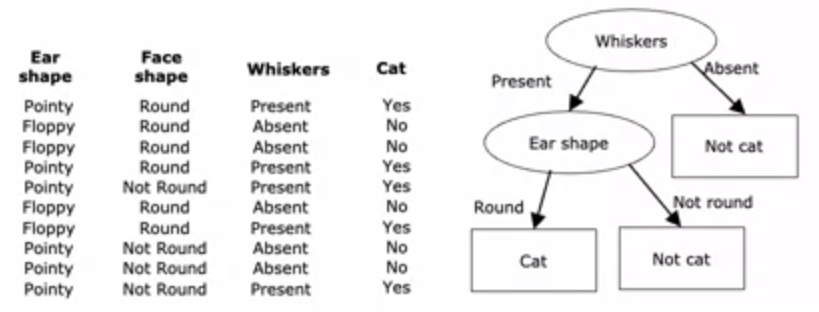

We then to back to the *original* data set (not generated via sampling with replacement) and look
at which examples this tree classifies correctly or incorrectly:

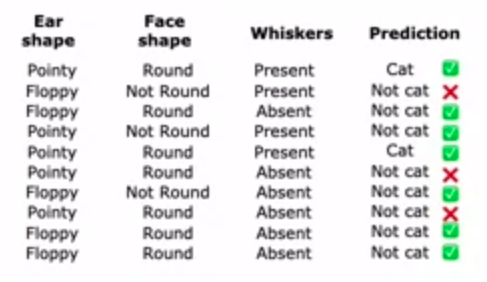

We would then increase the chances that the examples marked with red X's are chosen in the next iteration
of the XGBoost algorithm.



The math of how XGBoost increases the probability of choosing misclassified examples is a bit
complex, which is why there are nice open-source implementations out there.

XGBoost also has a few other nice things:
- Very fast.
- Good choice of default splitting criteria and criteria for when to stop splitting.
- Built-in regularization to prevent overfitting.
- Highly-used in real world situations and ML competitions.

## When to use decision trees

Decision trees and neural networks are two of the most commonly used machine learning algorithms. When should you use
each one?

Decision trees & tree ensemble methods:
- Work well on structured/tabular data.
- Not recommended for unstructured data (images, audio, text)
- Fast to train
- Small decision trees may be human-interpretable
- Most ML practitioners default to XGBoost for decision trees these days.

Neural networks
- (I say neural networks here but also include linear/logistic regression because anything linear/logistic can do,
a neural net can replicate.)
- Work well on all kinds of data, including structured and unstructured.
- Often slow to train; much slower than decision trees.